Public score: 0.442.

Private score: 0.433.

Main References:

Metric:
1. CMI | Best Single Model, https://www.kaggle.com/code/abdmental01/cmi-best-single-model .

Models:
1. Ensemble Modeling for Loan Approval by OMID BAGHCHEH SARAEI, https://www.kaggle.com/code/omidbaghchehsaraei/ensemble-modeling-for-loan-approval .
2. Loan Approval 🏦 Ensemble NN+XGB+LGBM+CAT by Mikhail Naumov, https://www.kaggle.com/code/mikhailnaumov/loan-approval-ensemble-nn-xgb-lgbm-cat .
3. Used Car Prices 🚗 Ensemble (no blending) by Mikhail Naumov, https://www.kaggle.com/code/mikhailnaumov/used-car-prices-ensemble-no-blending#Model-Training .
4. LB0.494 with TabNet, https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet .

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Importing Libraries</p>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc
from IPython.display import clear_output
from scipy.optimize import minimize
from colorama import Fore, Style

from sklearn import preprocessing
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from lightgbm import LGBMRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import ExtraTreesRegressor

import polars as pl
from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
random_seed = 42
n_fold = 5
oof = {}
test_pred = {}

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Load Data</p>

In [3]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    df['enmo'] = np.log(1+df['enmo'])
    df['light'] = np.log(1+df['light'])
    #df['cubic_root'] = np.cbrt(df['X'] * df['Y'] * df['Z'])
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [4]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
#time_series_cols = train_ts.columns.tolist()
#time_series_cols.remove("id")

100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


There are 996 rows and 97 columns in train_ts. Only 'id' column is of object type. All the other 96 statistical columns are float numbers. No missing values in train_ts.

There are 2 rows and 97 columns in test_ts. Only 'id' column is of object type. All the other 96 statistical columns are float numbers. No missing values in test_ts. 

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Data Exploration</p>

In [5]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

In [6]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train
test

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""00c0cd71""","""Winter""",7,0,"""Summer""",51,"""Spring""",29.315775,54.0,121.6,null,80,75,99,"""Spring""",4,5,32,"""Spring""",6,1,null,null,null,null,0,0,12.0,1,15.0,1,12.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",35,50,"""Winter""",2
"""00d56d4b""","""Spring""",5,1,"""Summer""",80,"""Spring""",17.284504,44.0,47.6,null,61,76,109,"""Spring""",null,null,null,"""Spring""",0,0,null,null,null,null,0,0,10.5,1,10.0,1,7.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",37,53,"""Spring""",0
"""00d9913d""","""Fall""",10,1,null,null,"""Fall""",19.893157,55.0,85.6,30.0,null,81,null,null,null,null,null,"""Fall""",5,0,null,null,null,null,0,0,0.0,0,0.0,0,9.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Fall""",1


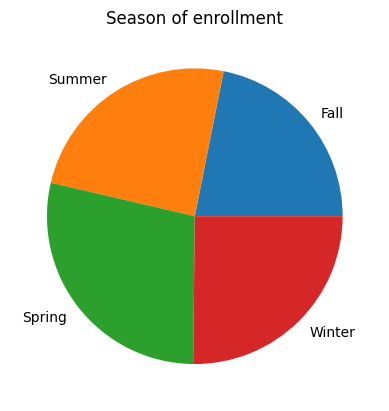

In [7]:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

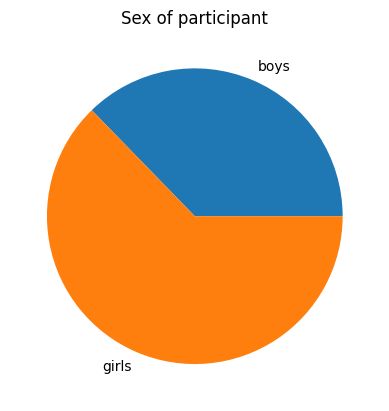

In [8]:
vc = train.get_column('Basic_Demos-Sex').value_counts()
plt.pie(vc.get_column('count'), labels=['boys', 'girls'])
plt.title('Sex of participant')
plt.show()

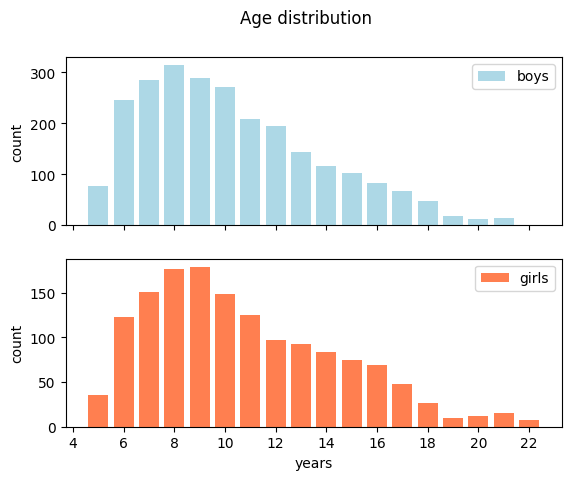

In [9]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

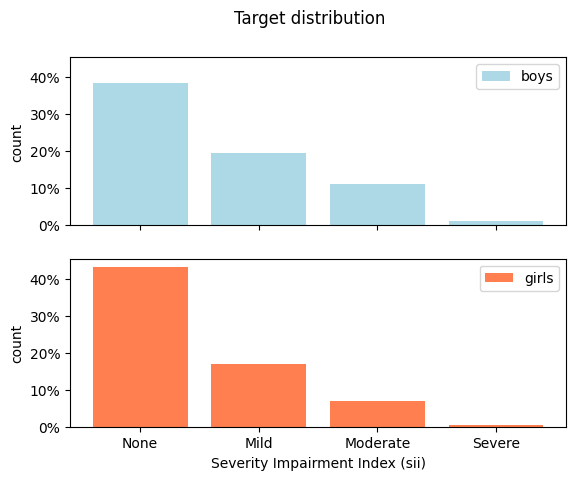

In [10]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

In [11]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

There are 3960 rows and 82 columns in train. 12 columns are of object type, including ['id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']. 70 columns are of numerical type. 78 columns have missing values. Only 4 columns do not have missing values, including 'id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age' and 'Basic_Demos-Sex'.

There are 20 rows and 59 columns in test. 11 columns are of object type, including ['id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']. 'PCIAT-Season' column only exsits in train, not in test. 48 columns are of numerical type. 55 columns have missing values. Only 4 columns do not have missing values, including 'id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age' and 'Basic_Demos-Sex'.

In [12]:
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

Now there are 3960 rows and 177 columns in train. 11 columns are of object type, including ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']. 166 columns are of numerical type. 174 columns have missing values. Only 3 columns do not have missing values, including 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age' and 'Basic_Demos-Sex'.

Now there are 20 rows and 154 columns in test. 10 columns are of object type, including ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']. 'PCIAT-Season' column only exsits in train, not in test. 144 columns are of numerical type. 151 columns have missing values. Only 3 columns do not have missing values, including Basic_Demos-Enroll_Season', 'Basic_Demos-Age' and 'Basic_Demos-Sex'.

Keep all the columns that exist in both train and test datasets. 

In [13]:
feature_cols = test.columns.to_list()

In [14]:
train = train[feature_cols + ['sii']]

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Feature Engineering</p>

Three are 1224 entries missing target variable 'sii' in train dataset.

In [15]:
train = train.dropna(subset='sii')

First fill in missing categorical variables then do oridnal encoding.

In [16]:
cat_cols = test.select_dtypes(include=['object']).columns.tolist()

def fill_missing(df):
    for col in cat_cols:
        df[col] = df[col].fillna('missing')
        
    return df

In [17]:
train = fill_missing(train)
test = fill_missing(test)

In [18]:
X_train = train.drop(['sii'], axis=1)
y_train = train['sii']

X_test = test

In [19]:
for col in cat_cols:
    enc = preprocessing.OrdinalEncoder(dtype=int)
    X_train[[col]] = enc.fit_transform(X_train[[col]])
    X_test[[col]] = enc.transform(X_test[[col]])    

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Cross Validation</p>

In [20]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [21]:
def cross_validation(model, label):

    val_S = []

    oof_non_rounded = np.zeros(len(X_train), dtype=float) 
    oof_rounded = np.zeros(len(X_train), dtype=int) 
    test_preds = np.zeros((len(X_test), n_fold))

    cv = StratifiedKFold(n_fold, shuffle=True, random_state=random_seed)
    cv_splits = cv.split(X_train, y_train)

    for fold, (train_idx, val_idx) in enumerate(cv_splits):

        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

        if 'xgb' in label:
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
        elif 'lgbm' in label:
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)])
        elif 'cb' in label:
            categorical_features_cols = X_test.columns[X_test.dtypes != float].to_list() 
            model.fit(X_train_fold, y_train_fold, cat_features=categorical_features_cols, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
        
        y_val_pred = model.predict(X_val_fold)

        oof_non_rounded[val_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[val_idx] = y_val_pred_rounded

        val_kappa = quadratic_weighted_kappa(y_val_fold, y_val_pred_rounded)
        val_S.append(val_kappa)
        
        y_pred = model.predict(X_test)
        test_preds[:, fold] = y_pred

        print(f"Fold {fold+1} - Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)
        gc.collect()
        
    print(f"Mean Validation QWK ---> {np.mean(val_S):.4f}")

    qwk_full = quadratic_weighted_kappa(y_train, oof_rounded)
    print(f"Full Train QWK --> {qwk_full:.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y_train, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y_train, oof_tuned)

    oof[label] = oof_tuned

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    test_pred[label] = tpTuned
    
    return tpTuned

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Lightgbm</p>

In [22]:
# https://www.kaggle.com/code/garfield2021/pss4e9-xgb-lgbm-cat
lgbm_params_1 = {
        'learning_rate': 0.01,
        'n_estimators': 2000,
        'num_leaves': 237, 
        'min_child_samples': 241, 
        'max_depth': 12, 
        'reg_alpha': 1.8869868007564816e-07, 
        'reg_lambda': 9.206863421105129e-06, 
        'colsample_bytree': 0.541469428945828, 
        'subsample': 0.6290239247477459, 
        'min_gain_to_split': 0.36460105927641795, 
        'bin_construct_sample_cnt': 119286,
        'random_state': random_seed,
        'verbosity': -1,
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'device': 'gpu',
        'eval_metric': 'l2',
        'early_stopping_round': 100
    }

In [23]:
%%time

tpTuned_lgbm_1 = cross_validation(LGBMRegressor(**lgbm_params_1), 'lgbm_1')

Mean Validation QWK ---> 0.3694
Full Train QWK --> 0.3696
----> || Optimized QWK SCORE ::  0.460
CPU times: user 16.6 s, sys: 901 ms, total: 17.5 s
Wall time: 11.6 s


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">XGBoost</p>

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">CatBoost</p>

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">(LinearRegression) Ensemble</p>

In [24]:
oof

{'lgbm_1': array([0, 0, 1, ..., 1, 1, 1])}

In [25]:
y_ensemble = train['sii']
X_ensemble = pd.DataFrame(oof)    
x_test_ensemble = pd.DataFrame(test_pred)

In [26]:
ensemble_val_S = []

ensemble_non_rounded = np.zeros(len(X_train), dtype=float) 
ensemble_rounded = np.zeros(len(X_train), dtype=int) 
ensemble_test_preds = np.zeros((len(X_test), n_fold))

skf = StratifiedKFold(n_fold, shuffle=True, random_state=random_seed)

for fold, (train_index_ens, val_index_ens) in enumerate(skf.split(X_ensemble, y_ensemble)):
    
    X_train_ens, X_val_ens = X_ensemble.iloc[train_index_ens], X_ensemble.iloc[val_index_ens]
    y_train_ens, y_val_ens = y_ensemble.iloc[train_index_ens], y_ensemble.iloc[val_index_ens]
    
    lr = LinearRegression().fit(X_train_ens, y_train_ens)

    ensemble_val_pred = lr.predict(X_val_ens)

    ensemble_non_rounded[val_index_ens] = ensemble_val_pred
    ensemble_val_pred_rounded = ensemble_val_pred.round(0).astype(int)
    ensemble_rounded[val_index_ens] = ensemble_val_pred_rounded

    ensemble_val_kappa = quadratic_weighted_kappa(y_val_ens, ensemble_val_pred_rounded)
    ensemble_val_S.append(ensemble_val_kappa)
        
    ensemble_test_preds[:, fold] = lr.predict(x_test_ensemble)

    print(f"Fold {fold+1} - Validation QWK: {ensemble_val_kappa:.4f}")
    clear_output(wait=True)
    #gc.collect()

print(f"Mean Validation QWK ---> {np.mean(ensemble_val_S):.4f}")

ensemble_qwk_full = quadratic_weighted_kappa(y_ensemble, ensemble_rounded)
print(f"Full Ensemble QWK --> {ensemble_qwk_full:.4f}")

KappaOPtimizer = minimize(evaluate_predictions,
                          x0=[0.5, 1.5, 2.5], args=(y_ensemble, ensemble_non_rounded), 
                          method='Nelder-Mead') # Nelder-Mead | # Powell
assert KappaOPtimizer.success, "Optimization did not converge."
    
ensemble_tuned = threshold_Rounder(ensemble_non_rounded, KappaOPtimizer.x)
ensemble_tKappa = quadratic_weighted_kappa(y_ensemble, ensemble_tuned)

print(f"----> || Optimized Ensemble QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {ensemble_tKappa:.3f}{Style.RESET_ALL}")

ensemble_tpm = ensemble_test_preds.mean(axis=1)
ensemble_tpTuned = threshold_Rounder(ensemble_tpm, KappaOPtimizer.x)

Mean Validation QWK ---> 0.3597
Full Ensemble QWK --> 0.3598
----> || Optimized Ensemble QWK SCORE ::  0.360


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Submission</p>

In [27]:
y_test = tpTuned_lgbm_1
submission = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
submission['sii'] = y_test
submission.to_csv('submission.csv', index=False)
submission['sii'].head()

0    0
1    0
2    1
3    0
4    1
Name: sii, dtype: int64